In [13]:
#import flair, torch
flair.device = torch.device('cpu') 

This part is importing the dataset, prepare it for preprocessing and processing.

In [4]:
import pandas as pd
train = pd.read_excel('PII_Train_Large_Data_Test_Data.xlsx',sheet_name=1)
train.columns = train[0:1].values[0]
train = train.drop(labels=0, axis=0).reset_index(drop=True)
train.head()

,Text,Labels,PII
0,Candidate economic character present money dau...,Address,Apt. 026
1,Film range sound. People age Apt. 476 that.,Address,Apt. 476
2,Back want myself class certain. Tree pretty ca...,Address,Suite 492
3,Bring guy 81627 Kimberly Squares Washingtonber...,Address,"81627 Kimberly Squares Washingtonberg, RI 13540"
4,"52013 Jason Vista Lake Kathleen, PA 89168 May ...",Address,"52013 Jason Vista Lake Kathleen, PA 89168"


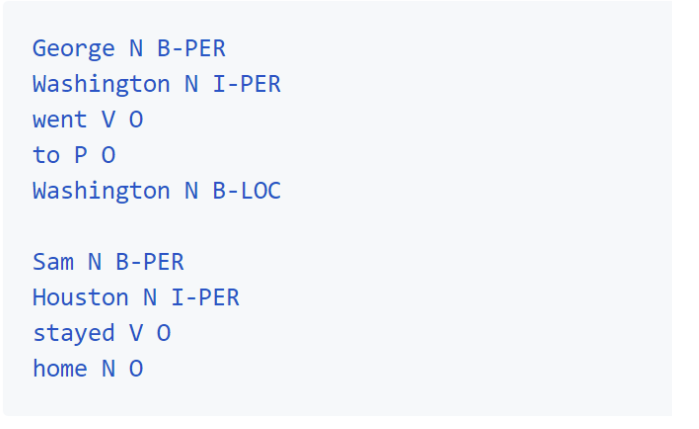
Flair library requires train data to be in this format. 

In [5]:
'''
I have to cast the PII column to be string because some of them 
starting at around row 101 (credit card numbers) are integer 
and that caused code that I used to breake.
I am not sure if you prepared the dataset intentionally to have integers or not 
but this gave me so much headache down the line, but i figured it out.
Also I should say that I liked it and if it was intentional it
was very smart move for testing my skills. 
'''
train['PII'] = train['PII'].astype('str')
train['Labels'] = train['Labels'].apply(str.upper)
# cast Labels and PII to a tuple list by zip
annotation = list(zip(train['PII'], train['Labels']))
aaa = []
for i in range(len(annotation)):
    aaa.append([annotation[i]])
train['annotation'] = aaa
# we do not need Labels and PII columns anymore
train = train.drop(columns=['Labels', 'PII'])
'''
we also do not need to have the bottom 100 rows to train the new NER 
since they do not have any entities to be recognized. 
'''
train = train.loc[:699]
train.columns = ['text', 'annotation']
train

#I put the data to this format because the guide that I was following was doing this way.


,text,annotation
0,Candidate economic character present money dau...,"[(Apt. 026, ADDRESS)]"
1,Film range sound. People age Apt. 476 that.,"[(Apt. 476, ADDRESS)]"
2,Back want myself class certain. Tree pretty ca...,"[(Suite 492, ADDRESS)]"
3,Bring guy 81627 Kimberly Squares Washingtonber...,"[(81627 Kimberly Squares Washingtonberg, RI 13..."
4,"52013 Jason Vista Lake Kathleen, PA 89168 May ...","[(52013 Jason Vista Lake Kathleen, PA 89168, A..."
...,...,...
695,Coach he west magazine against 510-81-5182 bea...,"[(510-81-5182, SSN)]"
696,Speech national especially 471 33 3655 availab...,"[(471 33 3655, SSN)]"
697,Forward listen step this community financial m...,"[(008-52-3159, SSN)]"
698,Test artist person billion. Trouble staff indu...,"[(818-43-7502, SSN)]"


In [37]:
import pandas as pd
from tqdm import tqdm
from difflib import SequenceMatcher
import re
import pickle

def matcher(string, pattern):
    '''
    Return the start and end index of any pattern present in the text.
    '''
    match_list = []
    pattern = pattern.strip()
    seqMatch = SequenceMatcher(None, string, pattern, autojunk=False)
    match = seqMatch.find_longest_match(0, len(string), 0, len(pattern))
    if (match.size == len(pattern)):
        start = match.a
        end = match.a + match.size
        match_tup = (start, end)
        string = string.replace(pattern, "X" * len(pattern), 1)
        match_list.append(match_tup)
        
    return match_list, string

def mark_sentence(s, match_list):
    '''
    Marks all the entities in the sentence as per the BIO scheme. 
    '''
    word_dict = {}
    for word in s.split():
        word_dict[word] = 'O'
        
    for start, end, e_type in match_list:
        temp_str = s[start:end]
        tmp_list = temp_str.split()
        if len(tmp_list) > 1:
            word_dict[tmp_list[0]] = 'B-' + e_type
            for w in tmp_list[1:]:
                word_dict[w] = 'I-' + e_type
        else:
            word_dict[temp_str] = 'B-' + e_type
    return word_dict

def clean(text):
    '''
    Just a helper fuction to add a space before the punctuations for better tokenization
    '''
    filters = ["!", "#", "$", "%", "&", "(", ")", "/", "*", ".", ":", ";", "<", "=", ">", "?", "@", "[",
               "\\", "]", "_", "`", "{", "}", "~", "'"]
    for i in text:
        if i in filters:
            text = text.replace(i, " " + i)
            
    return text

def create_data(df, filepath):
    '''
    The function responsible for the creation of data in the said format.
    '''
    # here in the original code that I used the encoding was not specified which took me some time to figure
    # out, and put the output files into required formats.
    with open(filepath , 'w',encoding='utf-8') as f:
        for text, annotation in zip(df.text, df.annotation):
            #text = clean(text)
            #text_ = text        
            match_list = []
            for i in annotation:
                a, text_ = matcher(text, i[0])
                match_list.append((a[0][0], a[0][1], i[1]))

            d = mark_sentence(text, match_list)

            for i in d.keys():
                f.writelines(i + ' ' + d[i] +'\n')
            f.writelines('\n')
            
def main():
 
    ## path to save the txt file. 
    ## run three times with train, test, and dev .txt filenames.
    ## as shown in the below screen shot snippet. 
    filepath = 'C:/Users/aileninferdi/Documents/Data Science/One Trust - Interview/training_custom_nerf/dev.txt'
    ## creating the file.
    create_data(train, filepath)
    
if __name__ == '__main__':
    main()

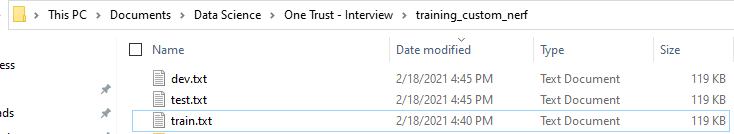
<br><br>
So we have these three files after we run the same code for three times to create these files with the given names. Because Flair library requires us to have these files in order to worka and accept the custom NER training. 
<br>This is normally not a good practice to have same files to train test and validate the model on the exactly same data but that is also related to limitations of this task. 
<br>Because, I have given only 100 samples of training data on each named entity (e.g. Email, SNN, Name, Creditcardnumber)

Now the data is ready for custom NER training with flair. 
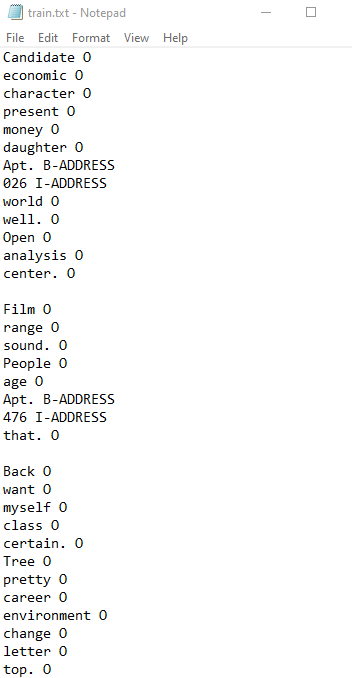

Reading the Corpus:
Finally, we are ready to load the corpus we have created and begin with the training. Let’s start with loading our corpus.

In [6]:
# imports
from flair.data import Corpus
from flair.datasets import ColumnCorpus

# define columns
columns = {0 : 'text', 1 : 'ner'}
# directory where the data resides
data_folder = 'C:/Users/aileninferdi/Documents/Data Science/One Trust - Interview/training_custom_nerf'
# initializing the corpus
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file = 'train.txt',
                              test_file = 'test.txt',
                              dev_file = 'dev.txt')

2021-02-18 20:41:45,907 Reading data from C:\Users\aileninferdi\Documents\Data Science\One Trust - Interview\training_custom_nerf
2021-02-18 20:41:45,910 Train: C:\Users\aileninferdi\Documents\Data Science\One Trust - Interview\training_custom_nerf\train.txt
2021-02-18 20:41:45,910 Dev: C:\Users\aileninferdi\Documents\Data Science\One Trust - Interview\training_custom_nerf\dev.txt
2021-02-18 20:41:45,911 Test: C:\Users\aileninferdi\Documents\Data Science\One Trust - Interview\training_custom_nerf\test.txt


In [7]:
# lenght of our corpus and one example of tagging.
print(len(corpus.train))
print(corpus.train[0].to_tagged_string('ner'))

700
Candidate economic character present money daughter Apt. <B-ADDRESS> 026 <I-ADDRESS> world well. Open analysis center.


In [8]:
# tag to predict
tag_type = 'ner'
# make tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

In [9]:
# here are a list of avalibale tags that we created, which aligns with our PII on initial data.
tag_dictionary.item2idx

{b'<unk>': 0,
 b'O': 1,
 b'B-ADDRESS': 2,
 b'I-ADDRESS': 3,
 b'B-CREDITCARDNUMBER': 4,
 b'B-EMAIL': 5,
 b'B-NAME': 6,
 b'I-NAME': 7,
 b'B-PHONE_NUMBER': 8,
 b'B-PLATES': 9,
 b'I-PLATES': 10,
 b'B-SSN': 11,
 b'I-SSN': 12,
 b'<START>': 13,
 b'<STOP>': 14}

In [11]:
from flair.embeddings import WordEmbeddings, StackedEmbeddings

from typing import List
embedding_types : List['TokenEmbeddings'] = [
        WordEmbeddings('glove'),
        ## other embeddings
        WordEmbeddings('crawl'),
        # ELMoEmbeddings() wanted to use this embedding since i read it improves the model accuracy significantly
        # I could not use it because it gives an error and after reading alot about it i concluded that 
        # it is related to cpu or cuda paramaeter which will take me some time to solve.
        ]
embeddings : StackedEmbeddings = StackedEmbeddings(
                                 embeddings=embedding_types)

Here we initialize a Sequence Tagger. We activate Conditional Random Fields with use_crf=True flag. On the backend training is being done by bi-directional LSTM.  

In [14]:
from flair.models import SequenceTagger

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)
print(tagger)

SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): WordEmbeddings('crawl')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=400, out_features=400, bias=True)
  (rnn): LSTM(400, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=15, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)


Here we train our model.

In [15]:
from flair.trainers import ModelTrainer
trainer : ModelTrainer = ModelTrainer(tagger, corpus)
trainer.train('resources/taggers/example-ner',
              learning_rate=0.1,
              mini_batch_size=32,
              max_epochs=150)

2021-02-18 20:55:47,781 ----------------------------------------------------------------------------------------------------
2021-02-18 20:55:47,782 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings('glove')
    (list_embedding_1): WordEmbeddings('crawl')
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=400, out_features=400, bias=True)
  (rnn): LSTM(400, 256, batch_first=True, bidirectional=True)
  (linear): Linear(in_features=512, out_features=15, bias=True)
  (beta): 1.0
  (weights): None
  (weight_tensor) None
)"
2021-02-18 20:55:47,783 ----------------------------------------------------------------------------------------------------
2021-02-18 20:55:47,784 Corpus: "Corpus: 700 train + 700 dev + 700 test sentences"
2021-02-18 20:55:47,785 ----------------------------------------------------------------------------------------------------
2021-02-18 20:55:47,785 P

2021-02-18 21:00:17,439 epoch 5 - iter 2/22 - loss 3.26571155 - samples/sec: 104.58 - lr: 0.100000
2021-02-18 21:00:18,033 epoch 5 - iter 4/22 - loss 3.50566918 - samples/sec: 108.11 - lr: 0.100000
2021-02-18 21:00:18,590 epoch 5 - iter 6/22 - loss 3.45677487 - samples/sec: 115.32 - lr: 0.100000
2021-02-18 21:00:19,219 epoch 5 - iter 8/22 - loss 3.31531593 - samples/sec: 102.07 - lr: 0.100000
2021-02-18 21:00:19,781 epoch 5 - iter 10/22 - loss 3.25768538 - samples/sec: 114.29 - lr: 0.100000
2021-02-18 21:00:20,517 epoch 5 - iter 12/22 - loss 3.27886975 - samples/sec: 87.07 - lr: 0.100000
2021-02-18 21:00:21,117 epoch 5 - iter 14/22 - loss 3.27889974 - samples/sec: 106.84 - lr: 0.100000
2021-02-18 21:00:21,700 epoch 5 - iter 16/22 - loss 3.25945166 - samples/sec: 109.97 - lr: 0.100000
2021-02-18 21:00:22,277 epoch 5 - iter 18/22 - loss 3.19918387 - samples/sec: 111.11 - lr: 0.100000
2021-02-18 21:00:22,812 epoch 5 - iter 20/22 - loss 3.17043725 - samples/sec: 119.85 - lr: 0.100000
2021-

2021-02-18 21:02:42,669 epoch 10 - iter 12/22 - loss 2.26398154 - samples/sec: 117.86 - lr: 0.100000
2021-02-18 21:02:43,259 epoch 10 - iter 14/22 - loss 2.29437784 - samples/sec: 108.66 - lr: 0.100000
2021-02-18 21:02:43,783 epoch 10 - iter 16/22 - loss 2.28809857 - samples/sec: 122.37 - lr: 0.100000
2021-02-18 21:02:44,271 epoch 10 - iter 18/22 - loss 2.27944676 - samples/sec: 131.42 - lr: 0.100000
2021-02-18 21:02:44,835 epoch 10 - iter 20/22 - loss 2.28642367 - samples/sec: 113.88 - lr: 0.100000
2021-02-18 21:02:45,353 epoch 10 - iter 22/22 - loss 2.26955793 - samples/sec: 123.79 - lr: 0.100000
2021-02-18 21:02:45,354 ----------------------------------------------------------------------------------------------------
2021-02-18 21:02:45,355 EPOCH 10 done: loss 2.2696 - lr 0.1000000
2021-02-18 21:02:47,004 DEV : loss 1.7181410789489746 - score 0.6211
2021-02-18 21:02:47,044 BAD EPOCHS (no improvement): 0
saving best model
2021-02-18 21:03:03,184 -------------------------------------

2021-02-18 21:05:12,148 epoch 15 - iter 20/22 - loss 2.08350470 - samples/sec: 111.31 - lr: 0.100000
2021-02-18 21:05:12,670 epoch 15 - iter 22/22 - loss 2.04755552 - samples/sec: 122.84 - lr: 0.100000
2021-02-18 21:05:12,671 ----------------------------------------------------------------------------------------------------
2021-02-18 21:05:12,672 EPOCH 15 done: loss 2.0476 - lr 0.1000000
2021-02-18 21:05:14,333 DEV : loss 1.4302159547805786 - score 0.6622
2021-02-18 21:05:14,372 BAD EPOCHS (no improvement): 0
saving best model
2021-02-18 21:06:04,423 ----------------------------------------------------------------------------------------------------
2021-02-18 21:06:04,958 epoch 16 - iter 2/22 - loss 1.88151467 - samples/sec: 120.08 - lr: 0.100000
2021-02-18 21:06:05,554 epoch 16 - iter 4/22 - loss 1.69222230 - samples/sec: 107.56 - lr: 0.100000
2021-02-18 21:06:06,134 epoch 16 - iter 6/22 - loss 1.80688632 - samples/sec: 110.73 - lr: 0.100000
2021-02-18 21:06:06,711 epoch 16 - iter 

2021-02-18 21:07:29,243 BAD EPOCHS (no improvement): 2
2021-02-18 21:07:29,245 ----------------------------------------------------------------------------------------------------
2021-02-18 21:07:29,783 epoch 21 - iter 2/22 - loss 1.99172390 - samples/sec: 119.18 - lr: 0.100000
2021-02-18 21:07:30,422 epoch 21 - iter 4/22 - loss 1.88783497 - samples/sec: 100.31 - lr: 0.100000
2021-02-18 21:07:30,991 epoch 21 - iter 6/22 - loss 1.81314019 - samples/sec: 112.68 - lr: 0.100000
2021-02-18 21:07:31,469 epoch 21 - iter 8/22 - loss 1.80545639 - samples/sec: 134.45 - lr: 0.100000
2021-02-18 21:07:31,990 epoch 21 - iter 10/22 - loss 1.85352205 - samples/sec: 123.08 - lr: 0.100000
2021-02-18 21:07:32,574 epoch 21 - iter 12/22 - loss 1.88393113 - samples/sec: 109.78 - lr: 0.100000
2021-02-18 21:07:33,129 epoch 21 - iter 14/22 - loss 1.86654734 - samples/sec: 119.18 - lr: 0.100000
2021-02-18 21:07:33,757 epoch 21 - iter 16/22 - loss 1.82792617 - samples/sec: 102.07 - lr: 0.100000
2021-02-18 21:07

2021-02-18 21:08:54,095 epoch 26 - iter 6/22 - loss 1.79432627 - samples/sec: 126.48 - lr: 0.050000
2021-02-18 21:08:54,599 epoch 26 - iter 8/22 - loss 1.71129826 - samples/sec: 127.24 - lr: 0.050000
2021-02-18 21:08:55,131 epoch 26 - iter 10/22 - loss 1.72041589 - samples/sec: 120.53 - lr: 0.050000
2021-02-18 21:08:55,705 epoch 26 - iter 12/22 - loss 1.72057202 - samples/sec: 111.89 - lr: 0.050000
2021-02-18 21:08:56,259 epoch 26 - iter 14/22 - loss 1.70220144 - samples/sec: 115.73 - lr: 0.050000
2021-02-18 21:08:56,802 epoch 26 - iter 16/22 - loss 1.68412816 - samples/sec: 118.08 - lr: 0.050000
2021-02-18 21:08:57,401 epoch 26 - iter 18/22 - loss 1.66909503 - samples/sec: 107.02 - lr: 0.050000
2021-02-18 21:08:57,936 epoch 26 - iter 20/22 - loss 1.66567360 - samples/sec: 119.85 - lr: 0.050000
2021-02-18 21:08:58,516 epoch 26 - iter 22/22 - loss 1.67648466 - samples/sec: 110.92 - lr: 0.050000
2021-02-18 21:08:58,517 ---------------------------------------------------------------------

2021-02-18 21:11:53,931 epoch 31 - iter 14/22 - loss 1.61464140 - samples/sec: 105.26 - lr: 0.025000
2021-02-18 21:11:54,482 epoch 31 - iter 16/22 - loss 1.61929848 - samples/sec: 116.36 - lr: 0.025000
2021-02-18 21:11:55,175 epoch 31 - iter 18/22 - loss 1.60704796 - samples/sec: 92.75 - lr: 0.025000
2021-02-18 21:11:55,750 epoch 31 - iter 20/22 - loss 1.65472173 - samples/sec: 111.50 - lr: 0.025000
2021-02-18 21:11:56,354 epoch 31 - iter 22/22 - loss 1.68798707 - samples/sec: 106.14 - lr: 0.025000
2021-02-18 21:11:56,355 ----------------------------------------------------------------------------------------------------
2021-02-18 21:11:56,356 EPOCH 31 done: loss 1.6880 - lr 0.0250000
2021-02-18 21:11:58,137 DEV : loss 1.1006169319152832 - score 0.6717
2021-02-18 21:11:58,176 BAD EPOCHS (no improvement): 2
2021-02-18 21:11:58,177 ----------------------------------------------------------------------------------------------------
2021-02-18 21:11:58,712 epoch 32 - iter 2/22 - loss 1.88

2021-02-18 21:12:41,492 ----------------------------------------------------------------------------------------------------
2021-02-18 21:12:41,493 EPOCH 36 done: loss 1.6591 - lr 0.0125000
2021-02-18 21:12:43,319 DEV : loss 1.003129482269287 - score 0.6737
2021-02-18 21:12:43,359 BAD EPOCHS (no improvement): 3
2021-02-18 21:12:43,361 ----------------------------------------------------------------------------------------------------
2021-02-18 21:12:43,997 epoch 37 - iter 2/22 - loss 1.43260169 - samples/sec: 100.95 - lr: 0.012500
2021-02-18 21:12:44,649 epoch 37 - iter 4/22 - loss 1.52853435 - samples/sec: 98.46 - lr: 0.012500
2021-02-18 21:12:45,205 epoch 37 - iter 6/22 - loss 1.57669157 - samples/sec: 115.52 - lr: 0.012500
2021-02-18 21:12:45,799 epoch 37 - iter 8/22 - loss 1.56981041 - samples/sec: 108.60 - lr: 0.012500
2021-02-18 21:12:46,414 epoch 37 - iter 10/22 - loss 1.53770543 - samples/sec: 104.18 - lr: 0.012500
2021-02-18 21:12:47,090 epoch 37 - iter 12/22 - loss 1.605376

2021-02-18 21:13:27,369 epoch 42 - iter 2/22 - loss 2.06339121 - samples/sec: 111.89 - lr: 0.003125
2021-02-18 21:13:27,956 epoch 42 - iter 4/22 - loss 1.87605840 - samples/sec: 109.22 - lr: 0.003125
2021-02-18 21:13:28,565 epoch 42 - iter 6/22 - loss 1.84879067 - samples/sec: 105.29 - lr: 0.003125
2021-02-18 21:13:29,131 epoch 42 - iter 8/22 - loss 1.74077325 - samples/sec: 113.27 - lr: 0.003125
2021-02-18 21:13:29,640 epoch 42 - iter 10/22 - loss 1.70837045 - samples/sec: 125.98 - lr: 0.003125
2021-02-18 21:13:30,295 epoch 42 - iter 12/22 - loss 1.64598147 - samples/sec: 98.01 - lr: 0.003125
2021-02-18 21:13:30,792 epoch 42 - iter 14/22 - loss 1.61069485 - samples/sec: 129.03 - lr: 0.003125
2021-02-18 21:13:31,366 epoch 42 - iter 16/22 - loss 1.59013265 - samples/sec: 111.89 - lr: 0.003125
2021-02-18 21:13:31,924 epoch 42 - iter 18/22 - loss 1.55515395 - samples/sec: 115.32 - lr: 0.003125
2021-02-18 21:13:32,594 epoch 42 - iter 20/22 - loss 1.56242961 - samples/sec: 95.81 - lr: 0.003

2021-02-18 21:14:13,449 epoch 47 - iter 12/22 - loss 1.59261127 - samples/sec: 103.90 - lr: 0.001563
2021-02-18 21:14:14,060 epoch 47 - iter 14/22 - loss 1.62763093 - samples/sec: 105.09 - lr: 0.001563
2021-02-18 21:14:14,624 epoch 47 - iter 16/22 - loss 1.62290336 - samples/sec: 113.74 - lr: 0.001563
2021-02-18 21:14:15,248 epoch 47 - iter 18/22 - loss 1.62835152 - samples/sec: 102.90 - lr: 0.001563
2021-02-18 21:14:15,963 epoch 47 - iter 20/22 - loss 1.62556815 - samples/sec: 89.76 - lr: 0.001563
2021-02-18 21:14:16,627 epoch 47 - iter 22/22 - loss 1.60094911 - samples/sec: 96.68 - lr: 0.001563
2021-02-18 21:14:16,628 ----------------------------------------------------------------------------------------------------
2021-02-18 21:14:16,628 EPOCH 47 done: loss 1.6009 - lr 0.0015625
2021-02-18 21:14:18,482 DEV : loss 0.9825829863548279 - score 0.6655
2021-02-18 21:14:18,524 BAD EPOCHS (no improvement): 2
2021-02-18 21:14:18,526 ---------------------------------------------------------

2021-02-18 21:15:01,660 epoch 52 - iter 22/22 - loss 1.64715565 - samples/sec: 102.07 - lr: 0.000781
2021-02-18 21:15:01,661 ----------------------------------------------------------------------------------------------------
2021-02-18 21:15:01,662 EPOCH 52 done: loss 1.6472 - lr 0.0007813
2021-02-18 21:15:03,492 DEV : loss 0.9736869931221008 - score 0.6672
2021-02-18 21:15:03,529 BAD EPOCHS (no improvement): 3
2021-02-18 21:15:03,531 ----------------------------------------------------------------------------------------------------
2021-02-18 21:15:04,058 epoch 53 - iter 2/22 - loss 1.68759578 - samples/sec: 121.67 - lr: 0.000781
2021-02-18 21:15:04,705 epoch 53 - iter 4/22 - loss 1.57215485 - samples/sec: 99.38 - lr: 0.000781
2021-02-18 21:15:05,401 epoch 53 - iter 6/22 - loss 1.61873227 - samples/sec: 92.09 - lr: 0.000781
2021-02-18 21:15:06,072 epoch 53 - iter 8/22 - loss 1.57656178 - samples/sec: 95.67 - lr: 0.000781
2021-02-18 21:15:06,622 epoch 53 - iter 10/22 - loss 1.5375552

2021-02-18 21:15:47,556 ----------------------------------------------------------------------------------------------------
2021-02-18 21:15:48,182 epoch 58 - iter 2/22 - loss 1.48097396 - samples/sec: 102.60 - lr: 0.000195
2021-02-18 21:15:48,834 epoch 58 - iter 4/22 - loss 1.61740077 - samples/sec: 98.31 - lr: 0.000195
2021-02-18 21:15:49,502 epoch 58 - iter 6/22 - loss 1.52995916 - samples/sec: 96.10 - lr: 0.000195
2021-02-18 21:15:50,019 epoch 58 - iter 8/22 - loss 1.54763766 - samples/sec: 124.12 - lr: 0.000195
2021-02-18 21:15:50,676 epoch 58 - iter 10/22 - loss 1.51996061 - samples/sec: 97.56 - lr: 0.000195
2021-02-18 21:15:51,300 epoch 58 - iter 12/22 - loss 1.55740356 - samples/sec: 102.73 - lr: 0.000195
2021-02-18 21:15:51,973 epoch 58 - iter 14/22 - loss 1.56596737 - samples/sec: 95.52 - lr: 0.000195
2021-02-18 21:15:52,662 epoch 58 - iter 16/22 - loss 1.57178055 - samples/sec: 93.16 - lr: 0.000195
2021-02-18 21:15:53,308 epoch 58 - iter 18/22 - loss 1.54259211 - samples/se

{'test_score': 0.6744815148782687,
 'dev_score_history': [0.15214994487320838,
  0.22109533468559836,
  0.37593984962406013,
  0.46011131725417437,
  0.4765409383624655,
  0.4958677685950414,
  0.595260663507109,
  0.603415559772296,
  0.6120527306967986,
  0.6210826210826211,
  0.6381766381766382,
  0.6464454976303318,
  0.633304572907679,
  0.6577946768060836,
  0.6622264509990486,
  0.6628679962013295,
  0.6615969581749049,
  0.6679316888045541,
  0.6666666666666667,
  0.6666666666666667,
  0.6666666666666667,
  0.6666666666666667,
  0.669165885660731,
  0.6729323308270677,
  0.671683913452493,
  0.6723163841807911,
  0.6694214876033058,
  0.6704225352112676,
  0.6744815148782687,
  0.6739130434782609,
  0.6716981132075471,
  0.6719022687609075,
  0.6648983200707338,
  0.6683937823834196,
  0.6717044500419815,
  0.673721340388007,
  0.6677658697444354,
  0.6723842195540308,
  0.6702033598585323,
  0.6677713338856669,
  0.6683333333333333,
  0.6700083542188805,
  0.6717687074829932,


We test random a sentence here.

In [25]:
from flair.data import Sentence
from flair.models import SequenceTagger
# load the trained model
model = SequenceTagger.load('C:\\Users\\aileninferdi\\Documents\\Data Science\\One Trust - Interview\\resources\\taggers\\example-ner\\best-model.pt')
# create example sentence
sentence = Sentence('I love Berlin')
# predict the tags
model.predict(sentence)
print(sentence.to_tagged_string())

2021-02-18 21:37:00,346 loading file C:\Users\aileninferdi\Documents\Data Science\One Trust - Interview\resources\taggers\example-ner\best-model.pt
I love Berlin


Now we bring in our test data from the excel file sheet 2. And give it some shape. 


In [20]:
test_df = pd.read_excel('PII_Train_Large_Data_Test_Data.xlsx', sheet_name=2)
c = test_df.loc[0].to_list()
test_df.columns = c
test_df = test_df.drop(labels=0, axis=0)
list_of_sentences = test_df['Text'].values

In [217]:
# we check the lenght of our test dataset.
len(list_of_sentences)

16000

In [218]:
Text=[]
Label=[]
PII = []
for i in range(len(list_of_sentences)):
    sentence = Sentence(list_of_sentences[i])
    model.predict(sentence)
    foo = sentence.to_dict(tag_type='ner')
    Text.append(foo['text'])
    if len(foo['entities']) > 0:       
        Label.append(foo['entities'][0]['labels'][0])
        PII.append(foo['entities'][0]['text'])
    else:
        Label.append(None)
        PII.append(None)


In [219]:
predictions_df = pd.DataFrame(data=Text, columns=['Text'])
predictions_df['Label']=Label
predictions_df['PII']=PII

In [220]:
predictions_df

,Text,Label,PII
0,Term although process suddenly parent. Poor go...,ADDRESS (0.9911),5539 Donna Centers Suite 339
1,"356 Collins Highway New Kathleen, NM 10160 Rem...",ADDRESS (0.9147),"356 Collins Highway New Kathleen, NM 10160"
2,Appear job opportunity job. Piece 405 Callahan...,ADDRESS (0.9842),405 Callahan Knolls
3,During half leave simple west lose piece 859 D...,ADDRESS (0.9296),859 Daniel Fall Apt. 901 Larsonland
4,Peace when Apt. 910 enter left speak agree. Le...,ADDRESS (0.6024),Apt
...,...,...,...
15995,He glass career yard community occur each. Bac...,None,None
15996,Everything religious home likely attention. Co...,None,None
15997,Matter adult look president than although road...,None,None
15998,Social require avoid book seven court decade.,None,None


In [215]:
predictions_df.to_excel('PII Test Data - Predictions.xlsx')

In [221]:
pwd

'C:\\Users\\aileninferdi\\Documents\\Data Science\\One Trust - Interview'